In [2]:
import pmx
from pmx.utils import create_folder
from pmx import gmx, ligand_alchemy, jobscript
import sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
%pylab inline
from IPython.core.display import clear_output
import os,shutil
import re
import subprocess
import glob
import random
import pandas as pd
import importlib
if 'AZtutorial' in sys.modules:
    importlib.reload(sys.modules['AZtutorial'])
else:
    import AZtutorial
from AZtutorial import *
from IPython.display import Image


from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors, rdmolfiles, rdMolAlign, rdmolops, rdchem, PyMol, Crippen, PropertyMol
from rdkit import DataStructs
from rdkit import RDLogger

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Geometry import Point3D
from rdkit.Numerics.rdAlignment import GetAlignmentTransform
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdMolTransforms
from tqdm import tqdm
from copy import deepcopy

try:
    import cPickle as pickle
except:
    import pickle
import os
from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull


@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

Populating the interactive namespace from numpy and matplotlib


# Step -3. Set up paths for the workflow

In [2]:

# initialize the free energy environment object: it will store the main parameters for the calculations
fe = AZtutorial( )

# set the workpath
fe.workPath = 'workpath'
# set the path to the molecular dynamics parameter files
fe.mdpPath = 'input/mdppath'
# set the number of replicas (several repetitions of calculation are useful to obtain reliable statistics)
fe.replicas = 3
# provide the path to the protein structure and topology
fe.proteinPath = 'input/protein_amber'
# provide the path to the folder with ligand structures and topologies
fe.ligandPath = 'input/ligands'


os.environ['GMXLIB'] = "/home/ykhalak/private/gmx_share_top_w_new_vdwradii"

In [3]:
! echo $GMXLIB

/home/ykhalak/private/gmx_share_top_w_new_vdwradii


# Step -2. Select ligands

In [4]:
training_ligand_databse_fn="/home/ykhalak/Projects/ML_dG/pde2_dG/how_do_ligs_fit_in_pocket_4d09_protein/processed_69_cl13_ligs_in_4d09_for_ddG_calc.pickle"
with open(training_ligand_databse_fn, 'rb') as f:
    training_ligs = pickle.load(f)

reference_lig_name="JAN_PDE2_1345"
for i,l in enumerate(training_ligs):
    if(reference_lig_name in l.GetProp("ID")):
        print(i)
        reference_lig_id=i
        
reference_lig=training_ligs[reference_lig_id]

del training_ligand_databse_fn,training_ligs
import gc
gc.collect()

54


0

In [4]:
folder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4"
pocket_fit_folder=f"{folder}/morphing_annealing_4d09_filtered_subset/"

with open(pocket_fit_folder+"/step_0_urandom_picks_from_2D_no_core_repr.pickle", 'rb') as f:
    test_ligs = pickle.load(f)

In [ ]:
Draw.MolsToGridImage(test_ligs+[reference_lig],
                     legends=[l.GetProp("ID") for l in test_ligs+[reference_lig]],
                     subImgSize = (400,400), molsPerRow=5, maxMols=101)

# Step -1. Properly parametrize ligands

In [14]:
# parametrize in parallel
from multiprocessing import Process, Queue, Pool, TimeoutError, Lock

mp_lock = Lock()
cur_folder=os.path.abspath(os.getcwd())

def mp_worker(mol):
    mp_lock.acquire()
    print(mol.GetProp('ID'),"\t starting in process", os.getpid())
    mp_lock.release()
    
    mol_folder=f"{fe.ligandPath}/lig_{mol.GetProp('ID')}/"
    os.makedirs(mol_folder, exist_ok=True)
    
    mol_pdb=f"{mol_folder}/mol_gmx.pdb"
    if(not os.path.exists(mol_pdb)):
        with open(mol_pdb,"w") as f:
            f.write(rdmolfiles.MolToPDBBlock(mol))
            
    mol_itp=mol_folder+"/MOL.acpype/MOL_GMX.itp"
    if(not os.path.exists(mol_itp)):
        mol_file=mol_folder+"/MOL.mol"
        rdmolfiles.MolToMolFile(mol, mol_file)

        #find total charge
        totQ=rdmolops.GetFormalCharge(mol)

        #acpype
        os.chdir(mol_folder)
        mol_file = "MOL.mol"
        process = subprocess.Popen(['acpype', '-i', mol_file, '-a', 'gaff', '-c', 'bcc', '-b', "MOL", '-n', repr(totQ)],
                    stdout=subprocess.PIPE,
                    stderr=subprocess.PIPE)
        process.wait()
#         out=process.stdout.read().decode("utf-8")
#         err=process.stderr.read().decode("utf-8")
#         print(out)
#         print(err)

        os.system("sed '/\\[ moleculetype \\]/Q' MOL.acpype/MOL_GMX.itp > ffMOL.itp 2>&1")
        os.system("sed -n '/\\[ moleculetype \\]/,$p' MOL.acpype/MOL_GMX.itp > MOL.itp  2>&1")

#         #make sigmahole versions
#         os.system("python /home/ykhalak/custom_scripts/sigmahole.py -itp MOL.itp -pdb mol_gmx.pdb -ffitp ffMOL.itp"+\
#                   " -oitp MOL_sigmahole.itp -offitp ffMOL_sigmahole.itp -opdb mol_sigmahole.pdb"+\
#                   " -ff gaff -rule ibrahim 2>&1")

        os.chdir(cur_folder)
        
        mp_lock.acquire()
        if(not os.path.exists(mol_itp)):
            print(mol.GetProp('ID'),"\t parametrization failed.")
        else:
            print(mol.GetProp('ID'),"\t done parametrizing")
        mp_lock.release()
#         break;
    else:
        mp_lock.acquire()
        print(mol.GetProp('ID'),"\t previously done")
        mp_lock.release()
        
use_cores=4
with Pool(processes=use_cores) as pool:
    res=pool.map(mp_worker, test_ligs+[reference_lig])

print("Now the pool is closed and no longer available")

set4_78514 	 starting in process 15323
set4_142769 	 starting in process 15324
set4_9538 	 starting in process 15325
set4_3320 	 starting in process 15326
set4_3320 	 done parametrizing
set4_247127 	 starting in process 15326
set4_78514 	 done parametrizing
set4_140006 	 starting in process 15323
set4_9538 	 done parametrizing
set4_1268 	 starting in process 15325
set4_142769 	 done parametrizing
set4_19443 	 starting in process 15324
set4_140006 	 done parametrizing
set4_15176 	 starting in process 15323
set4_247127 	 done parametrizing
set4_5607 	 starting in process 15326
set4_1268 	 done parametrizing
set4_142400 	 starting in process 15325
set4_19443 	 done parametrizing
set4_49113 	 starting in process 15324
set4_15176 	 done parametrizing
set4_248679 	 starting in process 15323
set4_5607 	 done parametrizing
set4_20513 	 starting in process 15326
set4_20513 	 done parametrizing
set4_139082 	 starting in process 15326
set4_248679 	 done parametrizing
set4_70821 	 starting in proc

In [15]:
# parametrize in parallel
from multiprocessing import Process, Queue, Pool, TimeoutError, Lock

mp_lock = Lock()
cur_folder=os.path.abspath(os.getcwd())

def mp_worker(mol):
#     mp_lock.acquire()
    print(mol.GetProp('ID'),"\t starting in process", os.getpid())
#     mp_lock.release()
    
    mol_folder=f"{fe.ligandPath}/lig_{mol.GetProp('ID')}/"
    os.makedirs(mol_folder, exist_ok=True)
            
    mol_sigmahole_itp=mol_folder+"/MOL_sigmahole.itp"
    if(not os.path.exists(mol_sigmahole_itp)):
        mol_file=mol_folder+"/MOL.mol"
        rdmolfiles.MolToMolFile(mol, mol_file)

        #find total charge
        totQ=rdmolops.GetFormalCharge(mol)

        #acpype
        os.chdir(mol_folder)
        
        #make sigmahole versions
        os.system("python /home/ykhalak/custom_scripts/sigmahole.py -itp MOL.itp -pdb mol_gmx.pdb -ffitp ffMOL.itp"+\
                  " -oitp MOL_sigmahole.itp -offitp ffMOL_sigmahole.itp -opdb mol_sigmahole.pdb"+\
                  f" -q {totQ} -ff gaff -rule ibrahim 2>&1")

        os.chdir(cur_folder)
        
#         mp_lock.acquire()
        if(not os.path.exists(mol_sigmahole_itp)):
            print(mol.GetProp('ID'),"\t parametrization failed.")
        else:
            print(mol.GetProp('ID'),"\t done parametrizing")
#         mp_lock.release()
#         break;
    else:
#         mp_lock.acquire()
        print(mol.GetProp('ID'),"\t previously done")
#         mp_lock.release()
        
use_cores=4
with Pool(processes=use_cores) as pool:
    res=pool.map(mp_worker, test_ligs+[reference_lig])



set4_78514 	 starting in process 8892
set4_142769 set4_9538	 starting in process8895 set4_33208893	 starting in process  
	 starting in process  
8896
set4_78514 	 done parametrizing
set4_140006 	 starting in process 8892
set4_3320 	 done parametrizing
set4_247127 	 starting in process 8896
set4_9538 set4_142769	 done parametrizing
 set4_1268 	 done parametrizing	 starting in process
 set4_194438895 	 starting in process
 8893
set4_1268set4_140006  	 done parametrizing	 done parametrizing

set4_15176 	 starting in process 8892set4_142400 
	 starting in process 8895
set4_19443 	 done parametrizing
set4_49113 	 starting in process set4_247127 8893	 done parametrizing

set4_5607 	 starting in process 8896
set4_142400 	 done parametrizing
set4_375269 set4_5607	 starting in process 8895
set4_15176set4_49113   	 done parametrizing	 done parametrizing
set4_20513	 done parametrizing
 	 starting in processset4_142962
  set4_2486798896	 starting in process 
 	 starting in process8893 
8892
set4_

----------------
Step 0. Initialize working environment
-----------------

Here, we will define the paths to the protein and ligand topologies, as well as to the molecular dynamics parameter files (.mdp).

We will also set some main parameters: water model, salt concentration, number of simulation replicas to use.

In [8]:
# provide edges
fe.edges = [ [reference_lig.GetProp('ID'), mol.GetProp('ID')] for mol in test_ligs]
fe.simTypes = ['em','eq_posre','eq','transitions']
#fe.simTypes = ['em','eq','transitions']

# finally, let's prepare the overall free energy calculation directory structure
fe.prepareFreeEnergyDir( )


edge_JAN_PDE2_1345_set4_78514
edge_JAN_PDE2_1345_set4_140006
edge_JAN_PDE2_1345_set4_15176
edge_JAN_PDE2_1345_set4_248679
edge_JAN_PDE2_1345_set4_70821
edge_JAN_PDE2_1345_set4_27001
edge_JAN_PDE2_1345_set4_16669
edge_JAN_PDE2_1345_set4_142769
edge_JAN_PDE2_1345_set4_19443
edge_JAN_PDE2_1345_set4_49113
edge_JAN_PDE2_1345_set4_142962
edge_JAN_PDE2_1345_set4_204482
edge_JAN_PDE2_1345_set4_73591
edge_JAN_PDE2_1345_set4_143120
edge_JAN_PDE2_1345_set4_9538
edge_JAN_PDE2_1345_set4_1268
edge_JAN_PDE2_1345_set4_142400
edge_JAN_PDE2_1345_set4_375269
edge_JAN_PDE2_1345_set4_332445
edge_JAN_PDE2_1345_set4_46397
edge_JAN_PDE2_1345_set4_354040
edge_JAN_PDE2_1345_set4_3320
edge_JAN_PDE2_1345_set4_247127
edge_JAN_PDE2_1345_set4_5607
edge_JAN_PDE2_1345_set4_20513
edge_JAN_PDE2_1345_set4_139082
edge_JAN_PDE2_1345_set4_236772
edge_JAN_PDE2_1345_set4_14581
edge_JAN_PDE2_1345_set4_14099
edge_JAN_PDE2_1345_set4_331089
edge_JAN_PDE2_1345_set4_143139
edge_JAN_PDE2_1345_set4_119367
edge_JAN_PDE2_1345_set4_3817

`1a. Firstly, let's create a hybrid structure/topology for the two ligands forming an edge.
For that we will establish a mapping of atoms to be morphed between the molecules.`

In [17]:
# this command will map the atoms of all edges found in the 'fe' object
# bVerbose flag prints the output of the command
fe.atom_mapping(bVerbose=False, n_processes=8)
#fe.atom_mapping(bVerbose=True)

-----------------------
Performing atom mapping
-----------------------
edge_JAN_PDE2_1345_set4_19443
edge_JAN_PDE2_1345_set4_14099
edge_JAN_PDE2_1345_set4_142400
edge_JAN_PDE2_1345_set4_20513
edge_JAN_PDE2_1345_set4_70821
edge_JAN_PDE2_1345_set4_354040
edge_JAN_PDE2_1345_set4_78514
edge_JAN_PDE2_1345_set4_73591
edge_JAN_PDE2_1345_set4_139082
edge_JAN_PDE2_1345_set4_49113
edge_JAN_PDE2_1345_set4_331089
edge_JAN_PDE2_1345_set4_27001
edge_JAN_PDE2_1345_set4_143120
edge_JAN_PDE2_1345_set4_3320
edge_JAN_PDE2_1345_set4_375269
edge_JAN_PDE2_1345_set4_143139
edge_JAN_PDE2_1345_set4_142962
edge_JAN_PDE2_1345_set4_140006
edge_JAN_PDE2_1345_set4_247127
edge_JAN_PDE2_1345_set4_236772
edge_JAN_PDE2_1345_set4_15176
edge_JAN_PDE2_1345_set4_332445
edge_JAN_PDE2_1345_set4_14581
edge_JAN_PDE2_1345_set4_204482
edge_JAN_PDE2_1345_set4_9538
edge_JAN_PDE2_1345_set4_16669
edge_JAN_PDE2_1345_set4_248679
edge_JAN_PDE2_1345_set4_46397
edge_JAN_PDE2_1345_set4_381798
edge_JAN_PDE2_1345_set4_330032
edge_JAN_PDE2_

`1b. Secondly, we will construct a hybrid structure and topology based on the established mapping`

In [ ]:
# import importlib
# if 'AZtutorial' in sys.modules:
#     importlib.reload(sys.modules['AZtutorial'])
# else:
#     import AZtutorial
# from AZtutorial import *

# # initialize the free energy environment object: it will store the main parameters for the calculations
# fe = AZtutorial( )

# # set the workpath
# fe.workPath = 'workpath'
# # set the path to the molecular dynamics parameter files
# fe.mdpPath = 'input/mdppath'
# # set the number of replicas (several repetitions of calculation are useful to obtain reliable statistics)
# fe.replicas = 3
# # provide the path to the protein structure and topology
# fe.proteinPath = 'input/protein_amber'
# # provide the path to the folder with ligand structures and topologies
# fe.ligandPath = 'input/ligands'

# # provide edges
# fe.edges = [ [reference_lig.GetProp('ID'), mol.GetProp('ID')] for mol in test_ligs]
# fe.simTypes = ['em','eq_posre','eq','transitions']
# #fe.simTypes = ['em','eq','transitions']

# # finally, let's prepare the overall free energy calculation directory structure
# fe.prepareFreeEnergyDir( )

In [18]:
fe.hybrid_structure_topology(bVerbose=False, n_processes=1, DummyMassScale=0.001)

----------------------------------
Creating hybrid structure/topology
----------------------------------
edge_JAN_PDE2_1345_set4_78514
edge_JAN_PDE2_1345_set4_140006
edge_JAN_PDE2_1345_set4_15176
edge_JAN_PDE2_1345_set4_248679
edge_JAN_PDE2_1345_set4_70821
edge_JAN_PDE2_1345_set4_27001
edge_JAN_PDE2_1345_set4_16669
edge_JAN_PDE2_1345_set4_142769
edge_JAN_PDE2_1345_set4_19443
edge_JAN_PDE2_1345_set4_49113
edge_JAN_PDE2_1345_set4_142962
edge_JAN_PDE2_1345_set4_204482
edge_JAN_PDE2_1345_set4_73591
edge_JAN_PDE2_1345_set4_143120
edge_JAN_PDE2_1345_set4_9538
edge_JAN_PDE2_1345_set4_1268
edge_JAN_PDE2_1345_set4_142400
edge_JAN_PDE2_1345_set4_375269
edge_JAN_PDE2_1345_set4_332445
edge_JAN_PDE2_1345_set4_46397
edge_JAN_PDE2_1345_set4_354040
edge_JAN_PDE2_1345_set4_3320
edge_JAN_PDE2_1345_set4_247127
edge_JAN_PDE2_1345_set4_5607
edge_JAN_PDE2_1345_set4_20513
edge_JAN_PDE2_1345_set4_139082
edge_JAN_PDE2_1345_set4_236772
edge_JAN_PDE2_1345_set4_14581
edge_JAN_PDE2_1345_set4_14099
edge_JAN_PDE2_13

`1c. Generate position restraints for the ligands`

In [19]:
fe.hybrid_structure_restraints(bVerbose=False, n_processes=8)

-----------------------------------------------
Creating position restraints for hybrid ligands
-----------------------------------------------
edge_JAN_PDE2_1345_set4_19443
edge_JAN_PDE2_1345_set4_78514
edge_JAN_PDE2_1345_set4_70821
edge_JAN_PDE2_1345_set4_73591
edge_JAN_PDE2_1345_set4_142400
edge_JAN_PDE2_1345_set4_354040
edge_JAN_PDE2_1345_set4_20513
edge_JAN_PDE2_1345_set4_14099
edge_JAN_PDE2_1345_set4_49113
edge_JAN_PDE2_1345_set4_375269
edge_JAN_PDE2_1345_set4_140006
edge_JAN_PDE2_1345_set4_3320
edge_JAN_PDE2_1345_set4_143120
edge_JAN_PDE2_1345_set4_139082
edge_JAN_PDE2_1345_set4_27001
edge_JAN_PDE2_1345_set4_331089
edge_JAN_PDE2_1345_set4_15176
edge_JAN_PDE2_1345_set4_9538
edge_JAN_PDE2_1345_set4_247127
edge_JAN_PDE2_1345_set4_142962
edge_JAN_PDE2_1345_set4_16669
edge_JAN_PDE2_1345_set4_332445
edge_JAN_PDE2_1345_set4_143139
edge_JAN_PDE2_1345_set4_236772
edge_JAN_PDE2_1345_set4_248679
edge_JAN_PDE2_1345_set4_204482
edge_JAN_PDE2_1345_set4_46397
edge_JAN_PDE2_1345_set4_14581
edge

`1d. Finally, we assemble the ligand and ligand+protein systems, i.e. create structures and topologies that will be used further in the step 2.`

In [20]:
prot_extra_mols={}
prot_extra_mols["MG"]=1
prot_extra_mols["ZN"]=1
prot_extra_mols["SOL"]=88

fe.assemble_systems( filter_prot_water=True, prot_extra_mols=prot_extra_mols)

----------------------
Assembling the systems
----------------------
edge_JAN_PDE2_1345_set4_78514


/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/MDAnalysis/topology/PDBParser.py:330: UserWarning: Element information is absent or missing for a few atoms. Elements attributes will not be populated.
  warnings.warn("Element information is absent or missing for a few "
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:864: DeprecationWarning: Using the last letter of the segid for the chainID is now deprecated and will be changed in 2.0. In 2.0, the chainID attribute will be used if it exists, or a placeholder value.
  "exists, or a placeholder value.", DeprecationWarning)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.

edge_JAN_PDE2_1345_set4_140006
changing number of waters to 87
edge_JAN_PDE2_1345_set4_15176
changing number of waters to 87
edge_JAN_PDE2_1345_set4_248679
edge_JAN_PDE2_1345_set4_70821
changing number of waters to 87
edge_JAN_PDE2_1345_set4_27001
edge_JAN_PDE2_1345_set4_16669
changing number of waters to 87
edge_JAN_PDE2_1345_set4_142769
changing number of waters to 87
edge_JAN_PDE2_1345_set4_19443
changing number of waters to 87
edge_JAN_PDE2_1345_set4_49113
changing number of waters to 87
edge_JAN_PDE2_1345_set4_142962
edge_JAN_PDE2_1345_set4_204482
changing number of waters to 87
edge_JAN_PDE2_1345_set4_73591
changing number of waters to 87
edge_JAN_PDE2_1345_set4_143120
changing number of waters to 87
edge_JAN_PDE2_1345_set4_9538
edge_JAN_PDE2_1345_set4_1268
edge_JAN_PDE2_1345_set4_142400
changing number of waters to 87
edge_JAN_PDE2_1345_set4_375269
changing number of waters to 87
edge_JAN_PDE2_1345_set4_332445
edge_JAN_PDE2_1345_set4_46397
changing number of waters to 87
edge_JA

------------------
Step 2. Prepare equilibrium simulations.
---------------------
Prepare simulation boxes with solvent and ions.
Subsequently energy minimize the systems, prepare equilibrium simulations and start the runs.

`2a. Build boxes, solvate, add ions`

In [21]:
fe.boxWaterIons(    bBoxLig=True, bBoxProt=True, 
                    bWatLig=True, bWatProt=True,
                    bIonLig=True, bIonProt=True, n_processes=4 )

----------------
Box, water, ions
----------------
edge_JAN_PDE2_1345_set4_142769
edge_JAN_PDE2_1345_set4_9538
edge_JAN_PDE2_1345_set4_78514
edge_JAN_PDE2_1345_set4_3320


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!IndexFile has group UNL !! 

Group UNL will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_1268
edge_JAN_PDE2_1345_set4_140006
edge_JAN_PDE2_1345_set4_247127
edge_JAN_PDE2_1345_set4_19443


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_142400
edge_JAN_PDE2_1345_set4_15176
edge_JAN_PDE2_1345_set4_5607
edge_JAN_PDE2_1345_set4_49113


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_375269
edge_JAN_PDE2_1345_set4_20513
edge_JAN_PDE2_1345_set4_248679
edge_JAN_PDE2_1345_set4_142962


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_332445
edge_JAN_PDE2_1345_set4_139082
edge_JAN_PDE2_1345_set4_70821
edge_JAN_PDE2_1345_set4_204482


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_46397
edge_JAN_PDE2_1345_set4_236772
edge_JAN_PDE2_1345_set4_27001
edge_JAN_PDE2_1345_set4_73591


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_14581
edge_JAN_PDE2_1345_set4_354040
edge_JAN_PDE2_1345_set4_16669
edge_JAN_PDE2_1345_set4_143120


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group MG !! IndexFile has group UNL !! 

Group UNL will be replaced !!Group MG will be replaced !!

IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_14099
edge_JAN_PDE2_1345_set4_122495
edge_JAN_PDE2_1345_set4_139201
edge_JAN_PDE2_1345_set4_7027


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_331089
edge_JAN_PDE2_1345_set4_330032
edge_JAN_PDE2_1345_set4_7253
edge_JAN_PDE2_1345_set4_246317


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
IndexFile has group MG !! Group ZN will be replaced !!

IndexFile has group UNL !! Group MG will be replaced !!

IndexFile has group ZN !! Group UNL will be replaced !!

Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_143139
edge_JAN_PDE2_1345_set4_245705
edge_JAN_PDE2_1345_set4_143049
edge_JAN_PDE2_1345_set4_118258


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_119367
edge_JAN_PDE2_1345_set4_142655
edge_JAN_PDE2_1345_set4_139702
edge_JAN_PDE2_1345_set4_122291


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_381798
edge_JAN_PDE2_1345_set4_142735
edge_JAN_PDE2_1345_set4_249687
edge_JAN_PDE2_1345_set4_143104


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group MG !! IndexFile has group ZN !! 

Group MG will be replaced !!Group ZN will be replaced !!

IndexFile has group ZN !! 
IndexFile has group UNL !! 
Group UNL will be replaced !!
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_16025
edge_JAN_PDE2_1345_set4_16499
edge_JAN_PDE2_1345_set4_20488
edge_JAN_PDE2_1345_set4_8319


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_19999
edge_JAN_PDE2_1345_set4_39480
edge_JAN_PDE2_1345_set4_250469
edge_JAN_PDE2_1345_set4_39632


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_138825


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_73965
edge_JAN_PDE2_1345_set4_3832
edge_JAN_PDE2_1345_set4_145


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_138386


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_330787
edge_JAN_PDE2_1345_set4_3454


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 

edge_JAN_PDE2_1345_set4_330179



Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_138901


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_141573
edge_JAN_PDE2_1345_set4_17062


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_44871


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_44836


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_139402
edge_JAN_PDE2_1345_set4_44514
edge_JAN_PDE2_1345_set4_248170
edge_JAN_PDE2_1345_set4_216942


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_142463
edge_JAN_PDE2_1345_set4_354416
edge_JAN_PDE2_1345_set4_39725
edge_JAN_PDE2_1345_set4_382909


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_41156
edge_JAN_PDE2_1345_set4_20192
edge_JAN_PDE2_1345_set4_374461
edge_JAN_PDE2_1345_set4_141963


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_44967
edge_JAN_PDE2_1345_set4_45700
edge_JAN_PDE2_1345_set4_39509
edge_JAN_PDE2_1345_set4_117746


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_140392
edge_JAN_PDE2_1345_set4_43309
edge_JAN_PDE2_1345_set4_138406


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_13512
edge_JAN_PDE2_1345_set4_120557
edge_JAN_PDE2_1345_set4_73594


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_232
edge_JAN_PDE2_1345_set4_245681


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_6592
edge_JAN_PDE2_1345_set4_143174


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_28543


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_20471
edge_JAN_PDE2_1345_set4_620


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_248782
edge_JAN_PDE2_1345_set4_382210


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


DONE


`2b. Energy minimization.`<br>
Prepare the simulation and subsequently either<br>
 a) run locally (suitable for the tutorial purpose)<br>
 b) create jobscripts to submit to the cluster

In [22]:
fe.prepare_simulation( simType='em', bLig=True, bProt=True, n_processes=8  )

-----------------------------------------
Preparing simulation: em
-----------------------------------------
edge_JAN_PDE2_1345_set4_78514
edge_JAN_PDE2_1345_set4_20513
edge_JAN_PDE2_1345_set4_14099
edge_JAN_PDE2_1345_set4_73591
edge_JAN_PDE2_1345_set4_70821
edge_JAN_PDE2_1345_set4_19443
edge_JAN_PDE2_1345_set4_354040
edge_JAN_PDE2_1345_set4_142400
edge_JAN_PDE2_1345_set4_331089
edge_JAN_PDE2_1345_set4_139082
edge_JAN_PDE2_1345_set4_375269
edge_JAN_PDE2_1345_set4_143120
edge_JAN_PDE2_1345_set4_27001
edge_JAN_PDE2_1345_set4_3320
edge_JAN_PDE2_1345_set4_49113
edge_JAN_PDE2_1345_set4_140006
edge_JAN_PDE2_1345_set4_332445
edge_JAN_PDE2_1345_set4_143139
edge_JAN_PDE2_1345_set4_236772
edge_JAN_PDE2_1345_set4_142962
edge_JAN_PDE2_1345_set4_15176
edge_JAN_PDE2_1345_set4_247127
edge_JAN_PDE2_1345_set4_9538
edge_JAN_PDE2_1345_set4_16669
edge_JAN_PDE2_1345_set4_248679
edge_JAN_PDE2_1345_set4_204482
edge_JAN_PDE2_1345_set4_46397
edge_JAN_PDE2_1345_set4_14581
edge_JAN_PDE2_1345_set4_1268
edge_JAN_P

Running energy minimization locally (e.g. on a laptop) will take 10-15 minutes for one edge.<br>
You can use the command below for that.
If you do not want to wait that long and have an access to a cluster, skip this step and proceed to the next step.

In [ ]:
#fe.run_simulation_locally( simType='em', bProt=True, bLig=False, bVerbose=True, mdrun=["mdrun_threads_d"])

We can also submit the jobs to run on the cluster.<br>
This, naturally, requires some knowledge of the cluster available, queueing system and some dependencies. Several jobscript parameters allow to define the environment on the cluster. If there are additional cluster specifics, the jobscripts can be easily modified.<br>

Together with the jobscripts, a script `submit.py` will be generated. This script can be used to simply submit all the jobs to the cluster.

In [23]:
# set several parameters
#fe.JOBqueue = 'SGE'
#fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
#fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBqueue = 'SLURM'
fe.JOBsource = ['/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = []
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads_d'
#fe.JOBsimcpu = 20
fe.JOBsimtime = 2 # hours
#fe.JOBpartition = 'p20'

fe.JOBsimcpu = None
fe.JOBpartition = 'p20,p16,p10,p08'

# create the jobscripts
fe.prepare_jobscripts(simType='em', bProt=True, bLig=True)

---------------------------------------------
Preparing jobscripts for: em
---------------------------------------------
DONE


In [24]:
# set several parameters
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads_d'
fe.JOBsimcpu = 10
fe.JOBsimtime = 2 # hours

# create the jobscripts
fe.prepare_jobscripts(simType='em', bProt=True, bLig=True)

---------------------------------------------
Preparing jobscripts for: em
---------------------------------------------
DONE


# Check what stages are finished

In [20]:
print("protein:")

simType='em'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")
                


simType='eq_posre'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")
                
simType='eq'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")

protein:
	 em
	 eq_posre
	 eq
Not finished: edge_JAN_PDE2_1345_set4_27001 stateB 1
Not finished: edge_JAN_PDE2_1345_set4_27001 stateB 2
Not finished: edge_JAN_PDE2_1345_set4_27001 stateB 3


In [21]:
print("water:")

simType='em'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='water',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")
                
simType='eq'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='water',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")

water:
	 em
	 eq
Not finished: edge_JAN_PDE2_1345_set4_27001 stateB 1
Not finished: edge_JAN_PDE2_1345_set4_27001 stateB 2
Not finished: edge_JAN_PDE2_1345_set4_27001 stateB 3


# calculate water NPT separately, as no NVT_posre is needed

In [16]:
import importlib
import sys
importlib.reload(sys.modules['AZtutorial'])
from AZtutorial import AZtutorial

In [17]:
fe_water_only = AZtutorial( )
fe_water_only.workPath = 'workpath'
fe_water_only.mdpPath = 'input/mdppath'
fe_water_only.replicas = 3
fe_water_only.proteinPath = 'input/protein_amber'
fe_water_only.ligandPath = 'input/ligands'

fe_water_only.edges = [ [reference_lig.GetProp('ID'), mol.GetProp('ID')] for mol in test_ligs]
fe_water_only.simTypes = ['em','eq','transitions']
fe_water_only.prepareFreeEnergyDir( )

edge_JAN_PDE2_1345_set4_6446
edge_JAN_PDE2_1345_set4_343762
edge_JAN_PDE2_1345_set4_372869
edge_JAN_PDE2_1345_set4_383005
edge_JAN_PDE2_1345_set4_127487
edge_JAN_PDE2_1345_set4_362882
edge_JAN_PDE2_1345_set4_334778
edge_JAN_PDE2_1345_set4_315002
edge_JAN_PDE2_1345_set4_217657
edge_JAN_PDE2_1345_set4_215970
edge_JAN_PDE2_1345_set4_135358
edge_JAN_PDE2_1345_set4_254110
edge_JAN_PDE2_1345_set4_63960
edge_JAN_PDE2_1345_set4_135002
edge_JAN_PDE2_1345_set4_65807
edge_JAN_PDE2_1345_set4_14794
edge_JAN_PDE2_1345_set4_218795
edge_JAN_PDE2_1345_set4_361086
edge_JAN_PDE2_1345_set4_44025
edge_JAN_PDE2_1345_set4_218973
edge_JAN_PDE2_1345_set4_329462
edge_JAN_PDE2_1345_set4_135513
edge_JAN_PDE2_1345_set4_138912
edge_JAN_PDE2_1345_set4_335350
edge_JAN_PDE2_1345_set4_218662
edge_JAN_PDE2_1345_set4_365668
edge_JAN_PDE2_1345_set4_333927
edge_JAN_PDE2_1345_set4_193116
edge_JAN_PDE2_1345_set4_24853
edge_JAN_PDE2_1345_set4_219819
edge_JAN_PDE2_1345_set4_34537
edge_JAN_PDE2_1345_set4_257545
edge_JAN_PDE2_13

In [18]:
fe_water_only.prepare_simulation( simType='eq', bLig=True, bProt=False, n_processes=8)

# set several parameters
fe_water_only.JOBqueue = 'SLURM'
fe_water_only.JOBsource = ['/usr/local/gromacs/GMXRC2021']
fe_water_only.JOBmodules = []
fe_water_only.JOBbGPU = True
fe_water_only.JOBgmx = 'mdrun_threads'
fe_water_only.JOBsimcpu = 8
fe_water_only.JOBsimtime = 10 # hours
fe_water_only.JOBpartition = 'p08'
fe_water_only.prepare_jobscripts( simType='eq', bProt=False, bLig=True, job_folder_suffix="_water")

# # set several parameters
# fe_water_only.JOBqueue = 'SGE'
# fe_water_only.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
# fe_water_only.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
# fe_water_only.JOBbGPU = True
# fe_water_only.JOBgmx = 'mdrun_threads'
# fe_water_only.JOBsimcpu = 8
# fe_water_only.JOBsimtime = 24 # hours
# fe_water_only.prepare_jobscripts( simType='eq', bProt=False, bLig=True, job_folder_suffix="_water")

-----------------------------------------
Preparing simulation: eq
-----------------------------------------
edge_JAN_PDE2_1345_set4_127487
edge_JAN_PDE2_1345_set4_24853
edge_JAN_PDE2_1345_set4_6446
edge_JAN_PDE2_1345_set4_63960
edge_JAN_PDE2_1345_set4_217657
edge_JAN_PDE2_1345_set4_329462
edge_JAN_PDE2_1345_set4_218662
edge_JAN_PDE2_1345_set4_218795
edge_JAN_PDE2_1345_set4_343762
edge_JAN_PDE2_1345_set4_365668
edge_JAN_PDE2_1345_set4_333927
edge_JAN_PDE2_1345_set4_372869
edge_JAN_PDE2_1345_set4_135002
edge_JAN_PDE2_1345_set4_135513
edge_JAN_PDE2_1345_set4_219819
edge_JAN_PDE2_1345_set4_362882
edge_JAN_PDE2_1345_set4_383005
edge_JAN_PDE2_1345_set4_193116
edge_JAN_PDE2_1345_set4_334778
edge_JAN_PDE2_1345_set4_315002
edge_JAN_PDE2_1345_set4_17970
edge_JAN_PDE2_1345_set4_382742
edge_JAN_PDE2_1345_set4_374226
edge_JAN_PDE2_1345_set4_361086
edge_JAN_PDE2_1345_set4_215970
edge_JAN_PDE2_1345_set4_332790
edge_JAN_PDE2_1345_set4_332311
edge_JAN_PDE2_1345_set4_305950
edge_JAN_PDE2_1345_set4_1389

In [ ]:
fe_water_only.prepare_transitions( bGenTpr=True, bProt=False, bLig=True )

# set several parameters
fe_water_only.JOBqueue = 'SGE'
fe_water_only.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe_water_only.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe_water_only.JOBgmx = 'mdrun_threads'
fe_water_only.JOBsimcpu = 10
fe_water_only.JOBsimtime = 24 # hours
fe_water_only.prepare_jobscripts(simType='transitions', bProt=False, bLig=True,  job_folder_suffix="_water" )

In [ ]:
# set several parameters
fe_water_only.JOBqueue = 'SLURM'
fe_water_only.JOBsource = ['/usr/local/gromacs/GMXRC2021']
fe_water_only.JOBmodules = []
fe_water_only.JOBbGPU = True
fe_water_only.JOBgmx = 'mdrun_threads'
fe_water_only.JOBsimcpu = 8
fe_water_only.JOBsimtime = 24 # hours
fe_water_only.JOBpartition = 'p08'
fe_water_only.prepare_jobscripts( simType='transitions', bProt=False, bLig=True, job_folder_suffix="_water")

In [ ]:
fe_water_only.run_analysis( bProt=False, bLig=True, bVerbose=False)

In [ ]:
fe_water_only.analysis_summary()

# Posre only for Prot

`prepare and run NVT with simulated annealing to get the temp up smoothly`

In [30]:
fe.prepare_simulation( simType='eq_posre', bProt=True, bLig=False, n_processes=8)

-----------------------------------------
Preparing simulation: eq_posre
-----------------------------------------
edge_JAN_PDE2_1345_set4_70821
edge_JAN_PDE2_1345_set4_20513
edge_JAN_PDE2_1345_set4_78514
edge_JAN_PDE2_1345_set4_19443
edge_JAN_PDE2_1345_set4_73591
edge_JAN_PDE2_1345_set4_142400
edge_JAN_PDE2_1345_set4_354040
edge_JAN_PDE2_1345_set4_27001
edge_JAN_PDE2_1345_set4_14099
edge_JAN_PDE2_1345_set4_139082
edge_JAN_PDE2_1345_set4_140006
edge_JAN_PDE2_1345_set4_49113
edge_JAN_PDE2_1345_set4_143120
edge_JAN_PDE2_1345_set4_375269
edge_JAN_PDE2_1345_set4_3320
edge_JAN_PDE2_1345_set4_331089
edge_JAN_PDE2_1345_set4_236772
edge_JAN_PDE2_1345_set4_15176
edge_JAN_PDE2_1345_set4_14581
edge_JAN_PDE2_1345_set4_9538
edge_JAN_PDE2_1345_set4_332445
edge_JAN_PDE2_1345_set4_247127
edge_JAN_PDE2_1345_set4_143139
edge_JAN_PDE2_1345_set4_142962
edge_JAN_PDE2_1345_set4_248679
edge_JAN_PDE2_1345_set4_381798
edge_JAN_PDE2_1345_set4_1268
edge_JAN_PDE2_1345_set4_46397
edge_JAN_PDE2_1345_set4_5607
edge_

In [ ]:
#fe.run_simulation_locally( simType='eq_posre', bProt=True, bLig=False, bVerbose=True, mdrun=["mdrun_threads"])

In [23]:
fe.JOBqueue = 'SLURM'
fe.JOBsource = ['/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = []
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 20
fe.JOBsimtime = 2 # hours
fe.JOBpartition = 'p20'

fe.prepare_jobscripts(simType='eq_posre', bProt=True, bLig=False)

---------------------------------------------
Preparing jobscripts for: eq_posre
---------------------------------------------
DONE


In [31]:
# set several parameters
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 10
fe.JOBsimtime = 2 # hours

# create the jobscripts
fe.prepare_jobscripts(simType='eq_posre', bProt=True, bLig=False)

---------------------------------------------
Preparing jobscripts for: eq_posre
---------------------------------------------
DONE


### Check eq_posre completition

In [32]:
simType='eq_posre'
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")

`2c. Once the energy minimization has finished, we can prepare equilibrium simulations.`

In [34]:
#fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8, edges=stable_edges)
# fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8, edges=rerun_edges)

In [ ]:
#fe.run_simulation_locally( simType='eq', bProt=True, bLig=False, bVerbose=True, mdrun=["mdrun_threads"])

Again, prepare and submit the equilibrium simulation jobs to the cluster.<br>
This time the calculation will take longer (we are performing 6 ns simulations).<br>
On a node with a GPU and 8 CPUs simulations of ligand in water will take ~2 hours, ligand-protein complex will take ~10 hours.

In [63]:
# fe.JOBqueue = 'SLURM'
# fe.JOBsource = ['/usr/local/gromacs/GMXRC2021']
# fe.JOBmodules = []
# fe.JOBbGPU = True
# fe.JOBgmx = 'mdrun_threads'
# #fe.JOBsimcpu = 20
# fe.JOBsimtime = 23 # hours
# #fe.JOBpartition = 'p20'
# fe.JOBsimcpu = None
# fe.JOBpartition = 'p20,p16,p10,p08'

# #fe.prepare_jobscripts(simType='eq',  bLig=True, bProt=True, edges=stable_edges)
# #fe.prepare_jobscripts(simType='eq',  bLig=True, bProt=True, edges=stable_edges2)
# fe.prepare_jobscripts(simType='eq',  bLig=True, bProt=True, edges=rerun_edges)

---------------------------------------------
Preparing jobscripts for: eq
---------------------------------------------
DONE


In [36]:
#fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8, edges=rerun_edges)
fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8)

fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 20
fe.JOBsimtime = 24 # hours

# fe.prepare_jobscripts(simType='eq',  bLig=True, bProt=True, edges=rerun_edges)
fe.prepare_jobscripts(simType='eq',  bLig=True, bProt=True)

-----------------------------------------
Preparing simulation: eq
-----------------------------------------
edge_JAN_PDE2_1345_set4_73591
edge_JAN_PDE2_1345_set4_78514
edge_JAN_PDE2_1345_set4_70821
edge_JAN_PDE2_1345_set4_19443
edge_JAN_PDE2_1345_set4_142400
edge_JAN_PDE2_1345_set4_354040
edge_JAN_PDE2_1345_set4_20513
edge_JAN_PDE2_1345_set4_14099
edge_JAN_PDE2_1345_set4_375269
edge_JAN_PDE2_1345_set4_331089
edge_JAN_PDE2_1345_set4_3320
edge_JAN_PDE2_1345_set4_139082
edge_JAN_PDE2_1345_set4_27001
edge_JAN_PDE2_1345_set4_143120
edge_JAN_PDE2_1345_set4_49113
edge_JAN_PDE2_1345_set4_140006
edge_JAN_PDE2_1345_set4_332445
edge_JAN_PDE2_1345_set4_143139
edge_JAN_PDE2_1345_set4_247127
edge_JAN_PDE2_1345_set4_9538
edge_JAN_PDE2_1345_set4_16669
edge_JAN_PDE2_1345_set4_142962
edge_JAN_PDE2_1345_set4_236772
edge_JAN_PDE2_1345_set4_15176
edge_JAN_PDE2_1345_set4_119367
edge_JAN_PDE2_1345_set4_46397
edge_JAN_PDE2_1345_set4_1268
edge_JAN_PDE2_1345_set4_5607
edge_JAN_PDE2_1345_set4_204482
edge_JAN_PD

# exclude unstable edges

In [17]:
unstable_edges_names=[
    "edge_JAN_PDE2_1345_set4_27001",
    #"edge_JAN_PDE2_1345_set4_39509"
]

In [18]:
stable_edges={e:fe.edges[e] for e in fe.edges if e not in unstable_edges_names}
#print(stable_edges)
unstable_edges={e:fe.edges[e] for e in fe.edges if e in unstable_edges_names}
print(unstable_edges)

{'edge_JAN_PDE2_1345_set4_27001': ['JAN_PDE2_1345', 'set4_27001']}


# Run TI on the edges that finished eq

In [13]:
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 10
fe.JOBsimtime = 24 # hours
fe.prepare_jobscripts(simType='transitions',  bLig=True, bProt=True, edges=stable_edges )

---------------------------------------------
Preparing jobscripts for: transitions
---------------------------------------------
DONE


# Finish running eq on edge_JAN_PDE2_1345_set4_39509 stateB 3 water

In [15]:
saveabale_edges_names=[
    "edge_JAN_PDE2_1345_set4_39509"
]
saveable_edges={e:fe.edges[e] for e in fe.edges if e in saveabale_edges_names}

#fe.prepare_simulation(edges=saveable_edges, simType='eq', bProt=False, bLig=True, n_processes=8)

fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 10
fe.JOBsimtime = 12 # hours

fe.prepare_jobscripts(edges=saveable_edges, simType='eq',  bLig=True, bProt=False)

---------------------------------------------
Preparing jobscripts for: eq
---------------------------------------------
DONE


# Check if NPT complete now

In [22]:
print("water:")
                
simType='eq'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='water',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")

water:
	 eq
Not finished: edge_JAN_PDE2_1345_set4_27001 stateB 1
Not finished: edge_JAN_PDE2_1345_set4_27001 stateB 2
Not finished: edge_JAN_PDE2_1345_set4_27001 stateB 3


99


# (Re)run TI for missing

In [48]:
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 20
fe.JOBsimtime = 24 # hours
fe.prepare_jobscripts(simType='transitions',  bLig=True, bProt=True, edges=stable_edges )

---------------------------------------------
Preparing jobscripts for: transitions
---------------------------------------------
DONE


# rerun eq on the unstable edges
After manually clearing their folders

In [16]:
# no point. Every NPT sim crashed for this ligand.

# Check structure of unstable lig

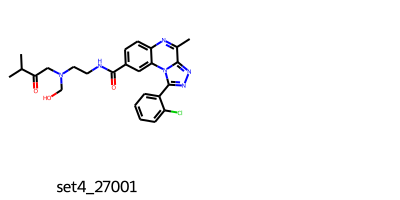

In [19]:
unstable_ligs=[]
unstable_lignames=[]
for i,l in enumerate(test_ligs):
    if("edge_JAN_PDE2_1345_"+l.GetProp("ID") in unstable_edges_names):
        unstable_ligs.append(l)
        unstable_lignames.append(l.GetProp("ID"))

Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(lig))for lig in unstable_ligs], legends=unstable_lignames,
                     subImgSize = (200,200), molsPerRow=2, maxMols=10)

----------------
Step 4. Analysis
------------------

`4a.` Firstly, let's process the calculated work values and estimate free energy differences.<br>
The `pmx analyse` program will integrate the dhdl.xvg files to obtain the forward and reverse work values.<br>
Subsequently, the Crooks fluctuation theorem and Jarzynski estimators will be applied to relate the work distributions to $\Delta G$

In [47]:
#fe.run_analysis( bVerbose=True)

# excluded=["edge_JAN_PDE2_1345_JAN_PDE2_994"] # we don't have water for this one yet
# ana_edges={x: fe.edges[x] for x in fe.edges if x not in excluded}
# fe.run_analysis(edges=ana_edges, bLig=False, bProt=True, bVerbose=False)

# fe.run_analysis( bLig=False, bProt=True, bVerbose=False)
#fe.run_analysis( bLig=True, bProt=True, bVerbose=False, only_check_completition=True)
fe.run_analysis( bLig=True, bProt=True, bVerbose=False, n_processes=8, edges=stable_edges)

----------------
Running analysis
----------------
edge_JAN_PDE2_1345_set4_375269
edge_JAN_PDE2_1345_set4_78514
edge_JAN_PDE2_1345_set4_143120
edge_JAN_PDE2_1345_set4_139082
edge_JAN_PDE2_1345_set4_70821
edge_JAN_PDE2_1345_set4_49113
edge_JAN_PDE2_1345_set4_3320
edge_JAN_PDE2_1345_set4_331089
edge_JAN_PDE2_1345_set4_16669
edge_JAN_PDE2_1345_set4_236772
edge_JAN_PDE2_1345_set4_332445
edge_JAN_PDE2_1345_set4_9538
edge_JAN_PDE2_1345_set4_143139
edge_JAN_PDE2_1345_set4_142962
edge_JAN_PDE2_1345_set4_140006
edge_JAN_PDE2_1345_set4_1268
edge_JAN_PDE2_1345_set4_46397
edge_JAN_PDE2_1345_set4_142769
edge_JAN_PDE2_1345_set4_14581
edge_JAN_PDE2_1345_set4_204482
edge_JAN_PDE2_1345_set4_119367
edge_JAN_PDE2_1345_set4_15176
edge_JAN_PDE2_1345_set4_14099
edge_JAN_PDE2_1345_set4_19443
edge_JAN_PDE2_1345_set4_354040
edge_JAN_PDE2_1345_set4_73591
edge_JAN_PDE2_1345_set4_248679
edge_JAN_PDE2_1345_set4_142400
edge_JAN_PDE2_1345_set4_381798
edge_JAN_PDE2_1345_set4_16025
edge_JAN_PDE2_1345_set4_143049
edge_

In [ ]:
not_finsished_edges_names=[
    "edge_JAN_PDE2_1345_set4_27001",
    "edge_JAN_PDE2_1345_set4_39509"
]

finished_edges={e:fe.edges[e] for e in fe.edges if e not in not_finsished_edges_names}

`4b.` Finally, we can collect all the results into one data structure and investigate the outcome.<br>
Let's also set the number of replicas back to 3, because results from three repeats have been pre-calculated for this tutorial.<br>
Here, we read the $\Delta G$ values and calculate $\Delta\Delta G$.<br>
The calculated error reflects the statistical uncertainty and the variation between multiple calculation repeats.

In [ ]:
fe.replicas = 3
fe.analysis_summary( edges=stable_edges )
#fe.analysis_summary()

In [29]:
fe.resultsAll

,val,err_analyt,err_boot,framesA,framesB
edge_JAN_PDE2_1345_set4_78514_water_1,-327.020000,1.380000,1.380000,80.0,80.0
edge_JAN_PDE2_1345_set4_78514_protein_1,-341.490000,2.790000,2.140000,80.0,80.0
edge_JAN_PDE2_1345_set4_78514_water_2,-330.150000,1.150000,1.140000,80.0,80.0
edge_JAN_PDE2_1345_set4_78514_protein_2,-347.950000,1.940000,1.560000,80.0,80.0
edge_JAN_PDE2_1345_set4_78514_water_3,-325.770000,1.570000,1.610000,80.0,80.0
...,...,...,...,...,...
edge_JAN_PDE2_1345_set4_382210_protein,65.093333,21.951266,2.420906,NaN,NaN
edge_JAN_PDE2_1345_set4_43309_water,4.056667,1.988176,1.503773,NaN,NaN
edge_JAN_PDE2_1345_set4_43309_protein,-16.956667,3.778634,3.042970,NaN,NaN
edge_JAN_PDE2_1345_set4_120557_water,19.276667,1.670492,1.279621,NaN,NaN


In [30]:
#fe.resultsSummary
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(fe.resultsSummary)

                                      val  err_analyt  err_boot
edge_JAN_PDE2_1345_set4_78514  -17.036667    2.447893  2.449380
edge_JAN_PDE2_1345_set4_140006  -5.573333    2.257949  2.243474
edge_JAN_PDE2_1345_set4_15176   -7.633333    2.331203  2.076678
edge_JAN_PDE2_1345_set4_248679 -10.520000    2.267558  2.093806
edge_JAN_PDE2_1345_set4_70821   -8.473333    4.735684  4.377164
edge_JAN_PDE2_1345_set4_16669   -9.063333    3.460516  2.687218
edge_JAN_PDE2_1345_set4_142769 -11.973333    3.477603  1.750645
edge_JAN_PDE2_1345_set4_19443   -0.893333    3.642972  2.847342
edge_JAN_PDE2_1345_set4_49113  -14.190000   15.779252  3.551628
edge_JAN_PDE2_1345_set4_142962  -1.850000    1.504556  1.453018
edge_JAN_PDE2_1345_set4_204482 -12.410000    3.898171  2.945664
edge_JAN_PDE2_1345_set4_73591  -12.533333    8.233585  4.440997
edge_JAN_PDE2_1345_set4_143120  -6.083333   12.107656  4.123926
edge_JAN_PDE2_1345_set4_9538     3.113333    3.810446  2.098984
edge_JAN_PDE2_1345_set4_1268    -8.61000

In [34]:
print(fe.resultsSummary.at["edge_JAN_PDE2_1345_set4_78514",'val'])
print()

-17.036666666666747


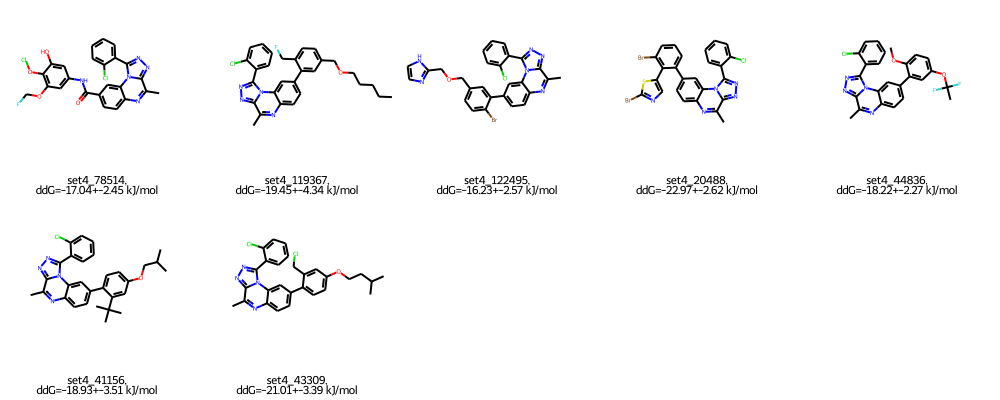

In [45]:
cutoff_ddg=-16
tight_binders=[]
legends=[]
for i,l in enumerate(test_ligs):
    edge=f"edge_JAN_PDE2_1345_{l.GetProp('ID')}"
    if(edge in finished_edges):
        val=fe.resultsSummary.at[edge,'val']
        uncert=fe.resultsSummary.at[edge,'err_boot']
        if(val<cutoff_ddg):
            tight_binders.append(Chem.MolFromSmiles(Chem.MolToSmiles(l)))
            legends.append(f"{l.GetProp('ID')},\nddG={val:.2f}+-{uncert:.2f} kJ/mol")
            
Draw.MolsToGridImage(tight_binders,
                     legends=legends,
                     subImgSize = (200,200), molsPerRow=5, maxMols=101)

40


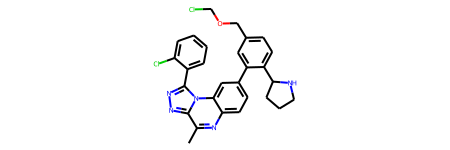

In [32]:
best_lig_name="set4_20488"
best_lig=None
for i,l in enumerate(test_ligs):
    if(best_lig_name in l.GetProp("ID")):
        print(i)
        best_lig=l
        
Chem.MolFromSmiles(Chem.MolToSmiles(l))

# save the stable ligs as a pickle for training

In [95]:
cal2J = 4.184
def lig_to_dG(lig):
    RT=0.001985875*300 #kcal/mol
    return(-RT*float(lig.GetProp('[V] hPDE2_pIC50'))*np.log(10))
red_dG=lig_to_dG(reference_lig)

save_ligs=[]
for edge in fe.resultsSummary.index:
    ligname=edge[19:]
    for lig in test_ligs:
        if lig.GetProp('ID')==ligname:
            lig.SetProp("ddG", str(fe.resultsSummary.loc[edge,'val']/cal2J) ) # kcal/mol
            lig.SetProp("dG", str(fe.resultsSummary.loc[edge,'val']/cal2J + red_dG) ) # kcal/mol
            lig.SetProp("dG_err", str(fe.resultsSummary.loc[edge,'err_boot']/cal2J) )  # kcal/mol
            save_ligs.append(PropertyMol.PropertyMol(lig))
            
print(len(save_ligs))

#fname="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09/ddG_step_0_sigmahole_scaled_dummy_masses/stable_ligs.pickle"
fname="stable_ligs.pickle"

with  open( fname, "wb" ) as f:
    pickle.dump(save_ligs, f)

93


In [5]:
# cal2J = 4.184
# def lig_to_dG(lig):
#     RT=0.001985875*300 #kcal/mol
#     return(-RT*float(lig.GetProp('[V] hPDE2_pIC50'))*np.log(10))

# print(f"ref lig dG: {lig_to_dG(reference_lig)} kcal/mol")

ref lig dG: -10.809735549543136 kcal/mol


In [7]:
# # fix the saved ligands' dG values
# fname="stable_ligs.pickle"
# with open(fname, 'rb') as f:
#     save_ligs = pickle.load(f)
    
# red_dG=lig_to_dG(reference_lig)
    
# for i,lig in enumerate(save_ligs):
#     ddG=float(lig.GetProp("ddG"))
#     lig.SetProp("dG", str(ddG + red_dG) ) # kcal/mol
#     save_ligs[i]=PropertyMol.PropertyMol(lig)
    
# fname="stable_ligs_fixed_dG.pickle"
# with  open( fname, "wb" ) as f:
#     pickle.dump(save_ligs, f)

# Also write dG value into the big 34K lig DB pickle file

In [5]:
all_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE.pickle"
with open(all_ligs_db_file, 'rb') as f:
    ligs_set4f = pickle.load(f)
    
with open("stable_ligs.pickle", 'rb') as f:
    step0_known_ligs = pickle.load(f)

known_lig_idxs_in_set4f=[]
known_lig_idxs_in_step0=[]
known_lig_idxs=[l.GetProp('ID') for l in step0_known_ligs]
for i,lig in enumerate(ligs_set4f):
    if(lig.GetProp('ID') in known_lig_idxs):
        known_lig_idxs_in_set4f.append(i)
        known_lig_idxs_in_step0.append(known_lig_idxs.index(lig.GetProp('ID')))

In [6]:
print(known_lig_idxs_in_step0)
print(known_lig_idxs_in_set4f)

[76, 91, 94, 14, 20, 63, 69, 22, 92, 48, 42, 46, 13, 90, 27, 26, 2, 32, 53, 5, 64, 7, 33, 74, 87, 39, 23, 93, 54, 98, 47, 80, 67, 96, 65, 58, 78, 75, 68, 18, 8, 4, 11, 84, 62, 0, 82, 43, 30, 97, 44, 34, 56, 83, 55, 57, 24, 41, 79, 37, 1, 89, 71, 61, 15, 66, 51, 52, 6, 9, 36, 45, 12, 29, 86, 10, 59, 25, 85, 50, 49, 21, 72, 3, 88, 38, 40, 35, 77, 70, 28, 17, 19, 73, 81, 16, 31, 95, 60]
[94, 178, 379, 670, 1508, 1564, 1650, 2545, 2827, 3004, 3062, 3611, 4072, 5195, 5414, 5517, 5832, 6518, 6882, 6993, 7186, 8219, 8515, 8593, 8817, 8834, 8858, 9647, 9869, 9892, 9988, 10033, 10575, 11078, 11671, 11889, 11923, 11958, 12271, 12503, 13123, 13653, 14189, 14191, 14287, 14532, 14780, 14849, 15060, 15153, 15281, 15422, 15521, 15541, 15960, 16036, 16217, 16336, 16536, 16836, 17140, 17525, 18706, 19096, 19530, 19593, 19784, 19864, 19898, 20091, 20178, 20233, 20249, 20268, 20303, 21553, 21784, 22407, 22615, 22637, 23179, 23838, 24718, 25139, 25223, 25892, 26540, 28163, 28310, 28761, 28962, 29560, 2992

In [7]:
for i in range(len(known_lig_idxs_in_step0)):
    idx_step0=known_lig_idxs_in_step0[i]
    idx_set4f=known_lig_idxs_in_set4f[i]
    
    #print(idx_step0, idx_set4f)
    
    old_lig=step0_known_ligs[idx_step0]
    new_lig=ligs_set4f[idx_set4f]
    

    new_lig.SetProp("ddG", old_lig.GetProp("ddG") ) # kcal/mol
    new_lig.SetProp("dG", old_lig.GetProp("dG") ) # kcal/mol
    new_lig.SetProp("dG_err", old_lig.GetProp("dG_err") ) # kcal/mol
    
    ligs_set4f[idx_set4f]=PropertyMol.PropertyMol(new_lig)
    
fname=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step0_dG.pickle"
with  open( fname, "wb" ) as f:
    pickle.dump(ligs_set4f, f)
    
del ligs_set4f

In [8]:
all_no_core_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs.pickle"

with open(all_no_core_ligs_db_file, 'rb') as f:
    no_core_ligs_set4f = pickle.load(f)
    
    
for i in range(len(known_lig_idxs_in_step0)):
    idx_step0=known_lig_idxs_in_step0[i]
    idx_set4f=known_lig_idxs_in_set4f[i]
    
    #print(idx_step0, idx_set4f)
    
    old_lig=step0_known_ligs[idx_step0]
    new_lig=no_core_ligs_set4f[idx_set4f]
    

    new_lig.SetProp("ddG", old_lig.GetProp("ddG") ) # kcal/mol
    new_lig.SetProp("dG", old_lig.GetProp("dG") ) # kcal/mol
    new_lig.SetProp("dG_err", old_lig.GetProp("dG_err") ) # kcal/mol
    
    no_core_ligs_set4f[idx_set4f]=PropertyMol.PropertyMol(new_lig)
    
fname=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step0_dG.pickle"
with  open( fname, "wb" ) as f:
    pickle.dump(no_core_ligs_set4f, f)
    
del no_core_ligs_set4f